# Filippo Conforto - RLab3

Some libraries are needed in order to store and plot the data.

In [4]:
library(tidyverse)
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Exercise 1

As usual, the four functions describing the probability distribution can be defined starting from the choosen interval (a,b) and the parameter c.
In particular the parameter c is defined as (a+b)/2 as default, and it corresponds to the distribution central value.

In [5]:
dtriang = function(x, a, b, c=(a+b)/2) {
    #Returns the pdf computed in x
    ifelse((x < c) & (x >= a), 2*(x-a)/((b-a)*(c-a)), ifelse((x <= b) & (x >= c), 2*(b-x)/((b-a)*(b-c)),0))
}

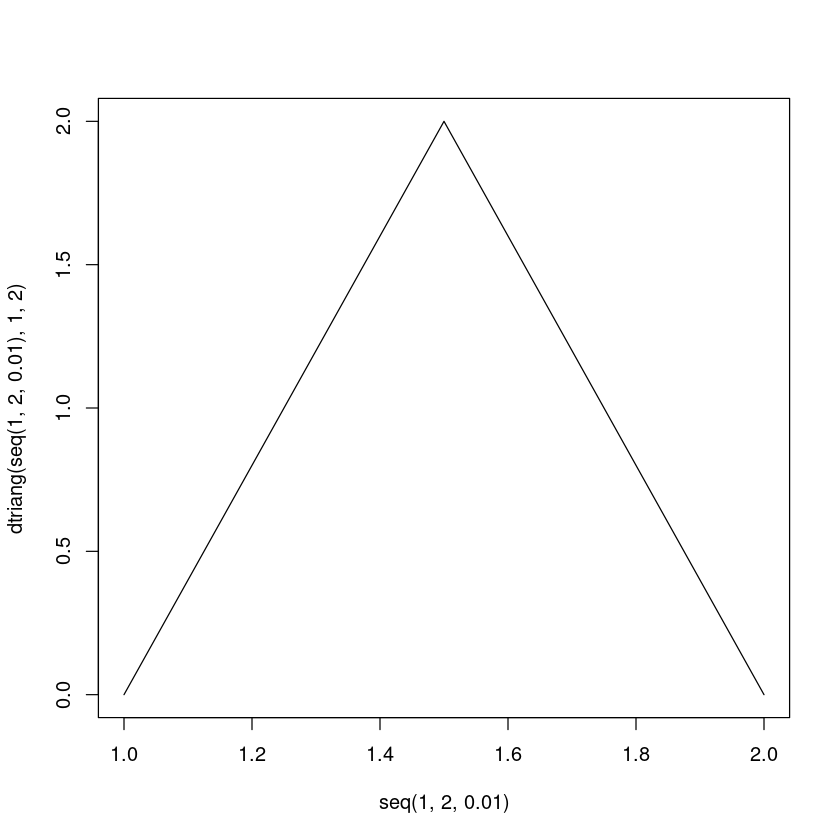

In [6]:
plot(seq(1,2,0.01),dtriang(seq(1,2,0.01),1,2), t= "l")

In [7]:
ptriang <- function (x, a,b, c=(a+b)/2) {
    # Returns the cdf computed in x
    k = (c-a)/(b-a)
    G = -(2*b*c -c^2)/((b-a)*(b-c)) + k
    return(ifelse((x < c) & (x >= a), ((x-a)^2)((b-a)*(c-a)), ifelse((x <= b) & (x >= c), (2*b*x-x^2)/((b-a)*(b-c))+G,0)))
}

In [8]:
qtriang <- function (p, a,b, c=(a+b)/2) {
    # Returns the quantile corresponding to the probability given
    k = (c-a)/(b-a)
    G = -(2*b*c -c^2)/((b-a)*(b-c)) + k
    return(ifelse(p < k , sqrt((b-a)*(c-a)*p)+a,b-sqrt(b^2+(b-a)*(b-c)*(G-p))))
}

In [9]:
rtriang <- function (n, a,b, c=(a+b)/2) {
    # Returns a set of simulated values, drawn from the distribution
    us = runif(n)
    k = (c-a)/(b-a)
    G = -(2*b*c -c^2)/((b-a)*(b-c)) + k
    return(ifelse(us < k , sqrt((b-a)*(c-a)*us)+a,b-sqrt(b^2+(b-a)*(b-c)*(G-us))))
}

Using the function rtriang previously defined a set of $10^4$ simulated samples can be obtained. These value and the corresponding theoretical ones are stored in a single dataframe in order to simplify the plot.

In [10]:
data = data.frame(samp = rtriang(10000,1,2), plot = dtriang(seq(1,2,l=10000),1,2), x = seq(1,2,l=10000))

The theoretical distribution is plotted along with the simulated data distribution. In particular the histogram is normalized to 1 in order to better visualize the two figures.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



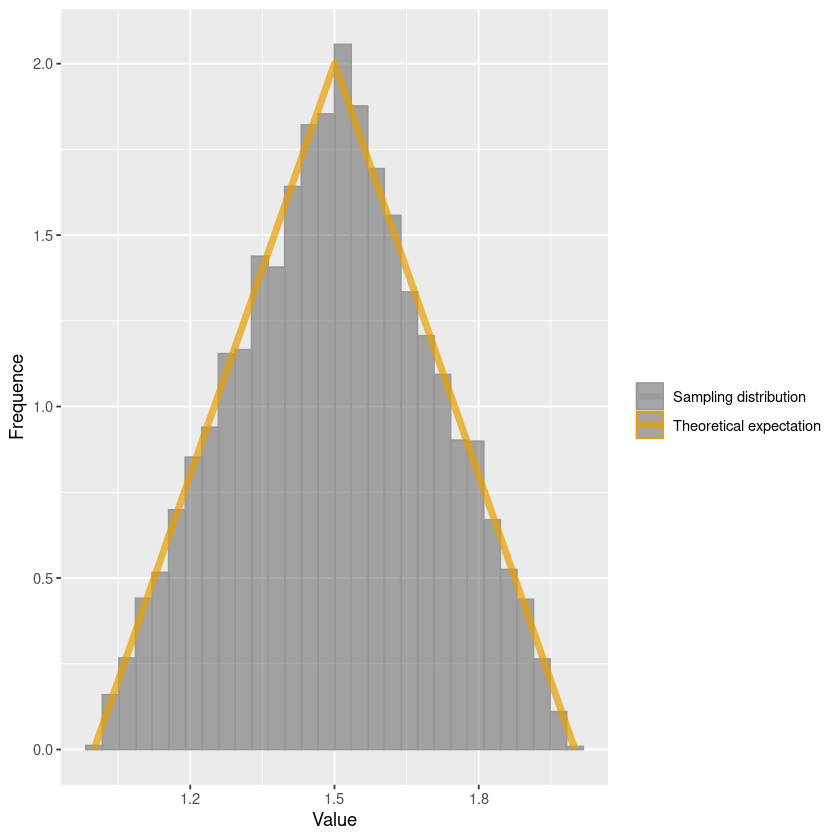

In [11]:
ggplot() + 
    geom_histogram(data = data, aes(x = samp, y=..density..,color = "Sampling distribution"), alpha = 0.5) +
    geom_line(data = data, aes(x = x, y = plot, color = "Theoretical expectation" ), size = 2, alpha = 0.7) +
    labs( x="Value", y= "Frequence", color = "") +
    scale_color_manual(values=c('#999999','#E69F00'))

## Exercise 2

The following function is used in order to simplify the computations.

In [12]:
G = function(f) {
    1-f
}

The results are obtainted using a serie of functions, args and a sequence of values for which the cdf are calculated using `invoke_map()`. Finally the cdf calculated are inverted using `G()` and the map functional.

In [13]:
funcs = list(pexp, punif, pbinom, ppois)
args = list( list(rate = 1),list(min=3,max=5),list(size=1,prob=1/2),list(lambda = 1/2))
results = invoke_map(funcs, args, seq(0,10,0.1))
results = map(results,G) 

Data are finally stored in a dataframe in order to plot them.

In [14]:
x = seq(0,10,0.1)
means= c(1,4,1/2,1)

In [15]:
data = data.frame( exp = results[[1]], unif = results[[2]], binom = results[[3]], pois = results[[4]], x=x)

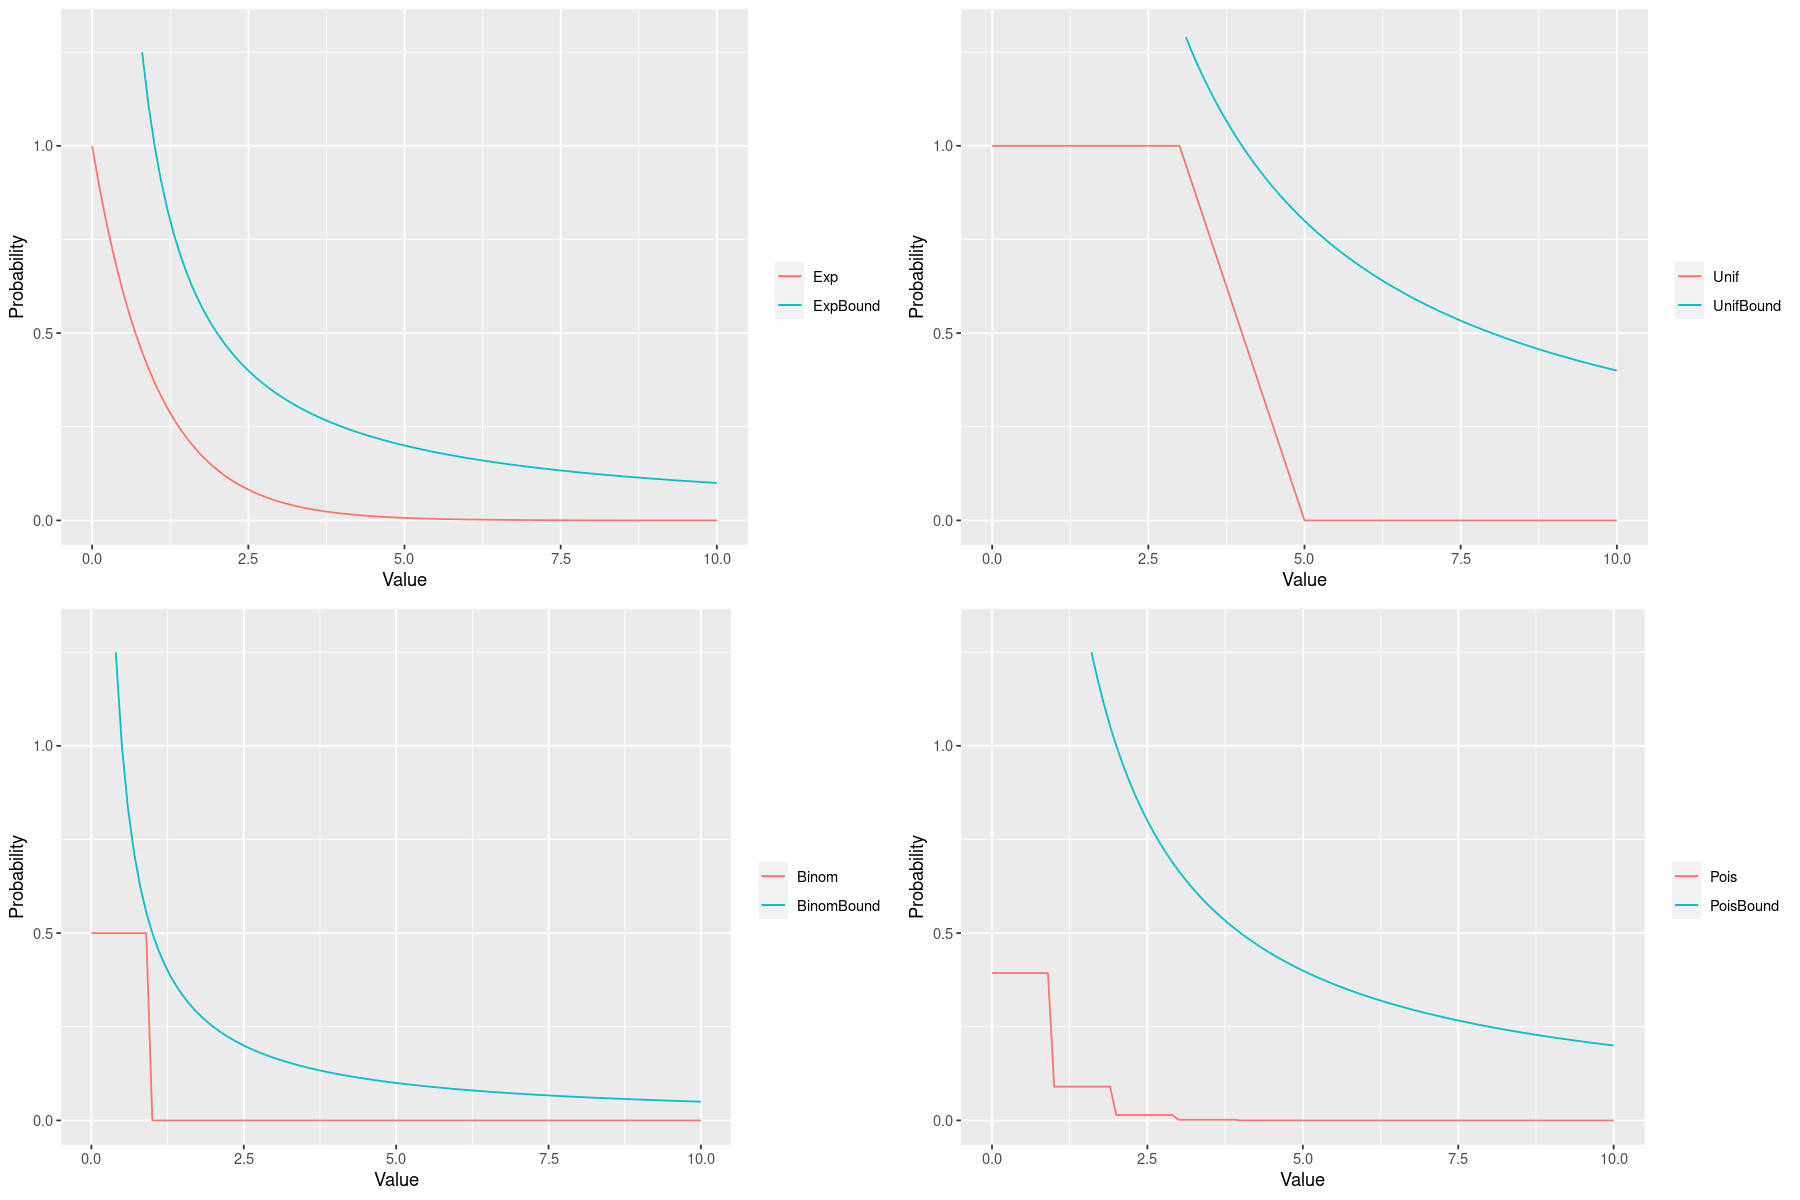

In [17]:
options(repr.plot.width=15, repr.plot.height=10)
p1=ggplot(data = data) + 
    geom_line(aes(x = x, y = exp, color = "Exp")) +
    geom_line(aes(x = x, y = 1/x, color = "ExpBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1.3)
p2 = ggplot(data = data) + 
    geom_line(aes(x = x, y = unif, color = "Unif")) +
    geom_line(aes(x = x, y = 4/x, color = "UnifBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1.3)
p3 = ggplot(data = data) + 
    geom_line(aes(x = x, y = binom, color = "Binom")) +
    geom_line(aes(x = x, y = 0.5/x, color = "BinomBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1.3)
p4 =ggplot(data = data) + 
    geom_line(aes(x = x, y = pois, color = "Pois")) +
    geom_line(aes(x = x, y = 2/x, color = "PoisBound")) +
    labs( x="Value", y= "Probability", color = "") +
    ylim(0,1.3)
grid.arrange(p1,p2,p3,p4,ncol=2,nrow=2)

The bound is respected as one should expect.

## Exercise 3

In order to test the Chebishev's inequality `intprob()` function is defined. This function allows to calculate the probability $$ P(|X- \mu| \geq k \sigma) = P(X \geq k \sigma + \mu) + P(X \leq \mu - k \sigma )$$

In [18]:
intprob = function(f,k, mean, var,args) {
    do.call(f,c(list(q=mean - k*var ), args)) + 1 - do.call(f,c(list(q=k*var + mean), args))
}

Using pmap and passing all cdf's argument, is possible to calculate the value of intprob for each distribution over k variation.

In [23]:
funcs = c(pnorm,pexp,punif, ppois)
args = list( list(mean = 3, sd=5),list(rate=1),list(min=1-sqrt(2), max = 1+sqrt(2)),list(lambda = 1/3))

res = list(f = funcs, k = list(seq(0,10,0.1),seq(0,10,0.1),seq(0,10,0.1),seq(0,10,0.1)), mean= c(3,1,1,1/3), var = c(5,1,2/3,1/3), args = args)  %>% pmap ( intprob )

In [20]:
x = seq(0,10,0.1)

data = data.frame( norm = res[[1]], exp = res[[2]], unif = res[[3]], pois = res[[4]], x=x)

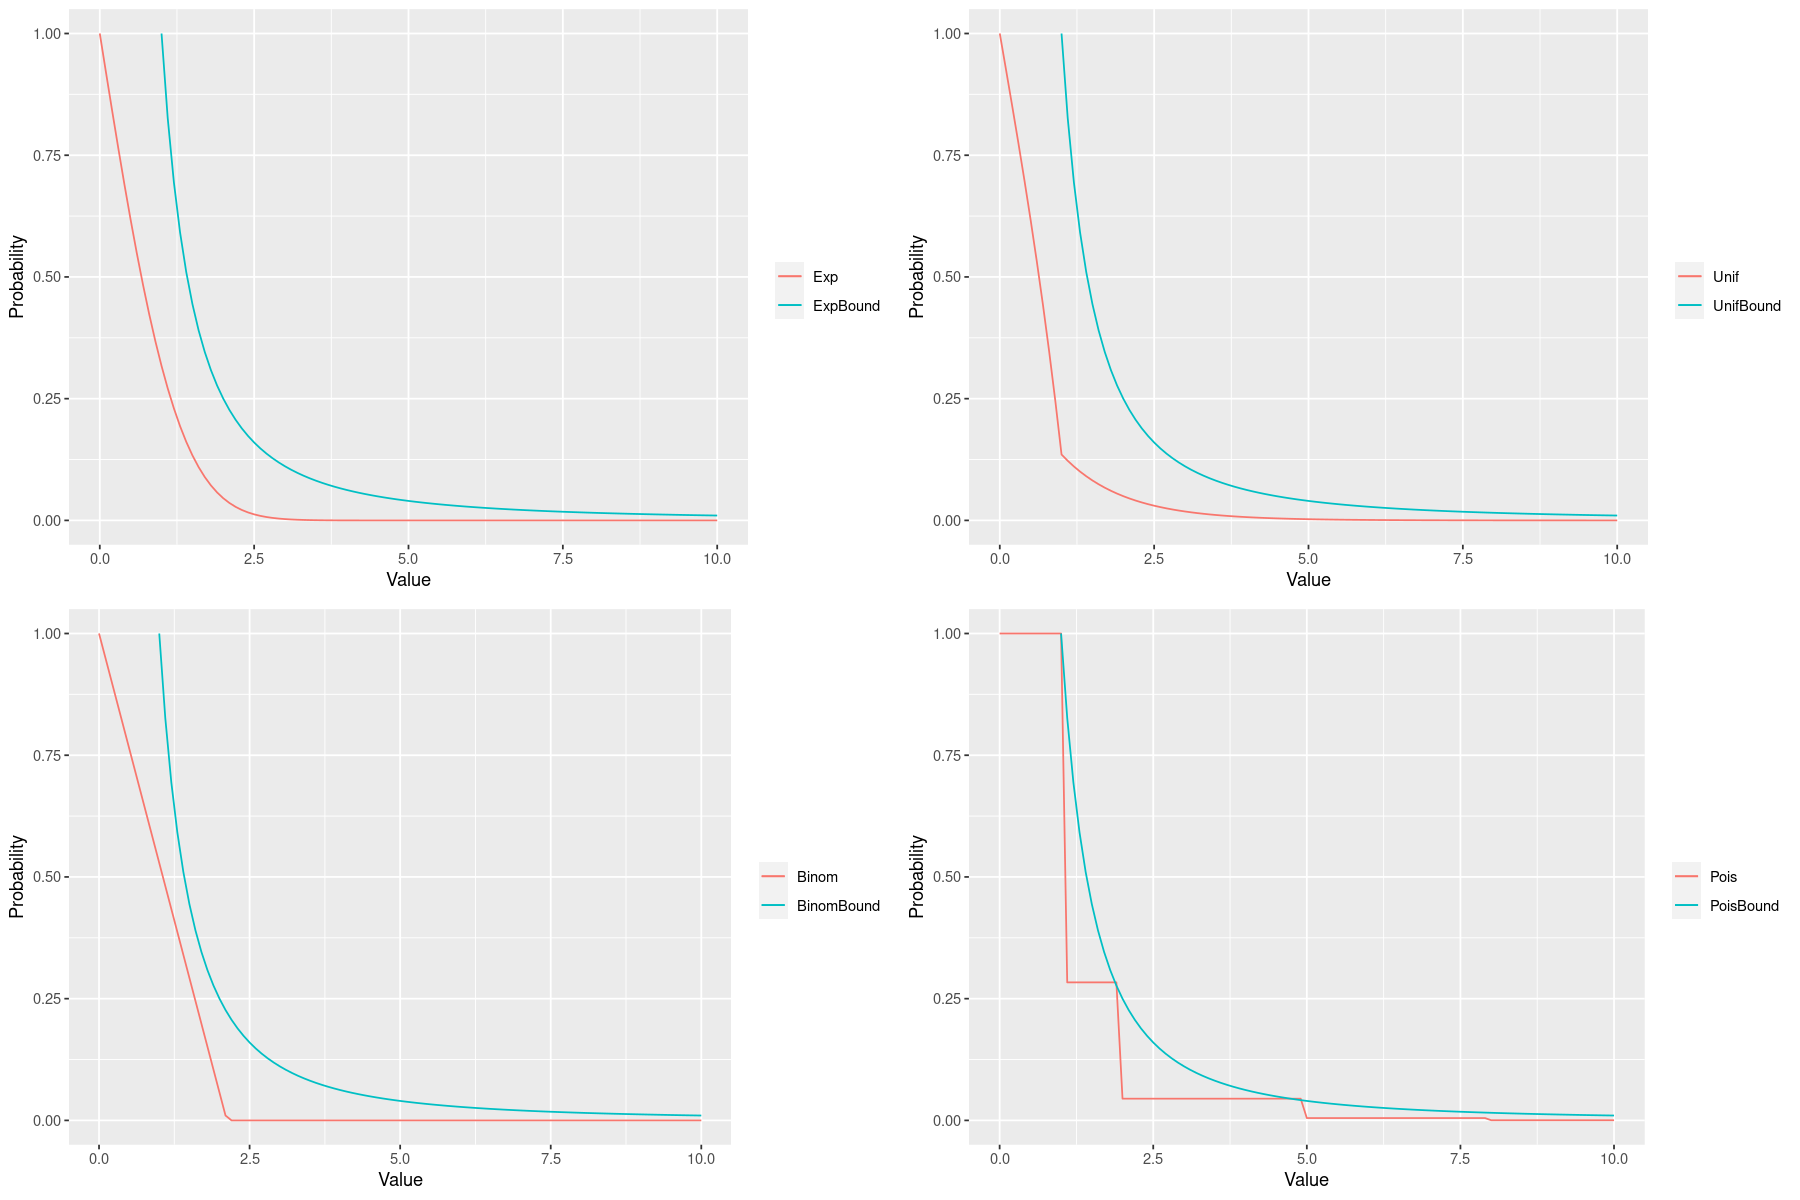

In [21]:
options(repr.plot.width=15, repr.plot.height=10)
p1=ggplot(data = data) + 
    geom_line(aes(x = x, y = norm, color = "Exp")) +
    geom_line(aes(x = x, y = 1/x^2, color = "ExpBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1)
p2 = ggplot(data = data) + 
    geom_line(aes(x = x, y = exp, color = "Unif")) +
    geom_line(aes(x = x, y = 1/x^2, color = "UnifBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1)
p3 = ggplot(data = data) + 
    geom_line(aes(x = x, y = unif, color = "Binom")) +
    geom_line(aes(x = x, y = 1/x^2, color = "BinomBound")) +
    labs( x="Value", y= "Probability", color = "")+
    ylim(0,1)
p4 =ggplot(data = data) + 
    geom_line(aes(x = x, y = pois, color = "Pois")) +
    geom_line(aes(x = x, y = 1/x^2, color = "PoisBound")) +
    labs( x="Value", y= "Probability", color = "") +
    ylim(0,1)
grid.arrange(p1,p2,p3,p4,ncol=2,nrow=2)

Chebishev's inequality is respected.

## Exercise 4

In order to discuss data they are loaded using `map_df` over a list of names, that allows to read values for a certain number of countries and insert them into a single dataframe.

In [24]:
read_gdata <- function ( country, dir) {
filename <- paste0( "2020_", country , "_Region_Mobility_Report.csv")
filepath <- file.path(dir , filename )
read_csv (filepath)
}

In [25]:
country = c("IT","JP","IN")
dir="./Region_Mobility_Report_CSVs"
gdata  = map_df( country , read_gdata, dir)

# Mutate is used to transform dates into week specification
gdata = mutate(gdata, date = lubridate::week(date))
# Check used to removed single region data
gdata = gdata[is.na(gdata$sub_region_1) ,]


── Column specification ────────────────────────────────────────────────────────
cols(
  country_region_code = col_character(),
  country_region = col_character(),
  sub_region_1 = col_character(),
  sub_region_2 = col_character(),
  metro_area = col_logical(),
  iso_3166_2_code = col_character(),
  census_fips_code = col_logical(),
  place_id = col_character(),
  date = col_date(format = ""),
  retail_and_recreation_percent_change_from_baseline = col_double(),
  grocery_and_pharmacy_percent_change_from_baseline = col_double(),
  parks_percent_change_from_baseline = col_double(),
  transit_stations_percent_change_from_baseline = col_double(),
  workplaces_percent_change_from_baseline = col_double(),
  residential_percent_change_from_baseline = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  country_region_code = col_character(),
  country_region = col_character(),
  sub_region_1 = col_character(),
  sub_region_2 = col_logical(

A 

In [27]:
week_gdata = gdata %>% group_by(country_region, date) %>% summarise (ret_recr_mean = mean(retail_and_recreation_percent_change_from_baseline), 
                                                            transit_mean = mean(transit_stations_percent_change_from_baseline),
                                                            work_mean = mean(workplaces_percent_change_from_baseline),
                                                            home_mean = mean(residential_percent_change_from_baseline))

`summarise()` has grouped output by 'country_region'. You can override using the `.groups` argument.



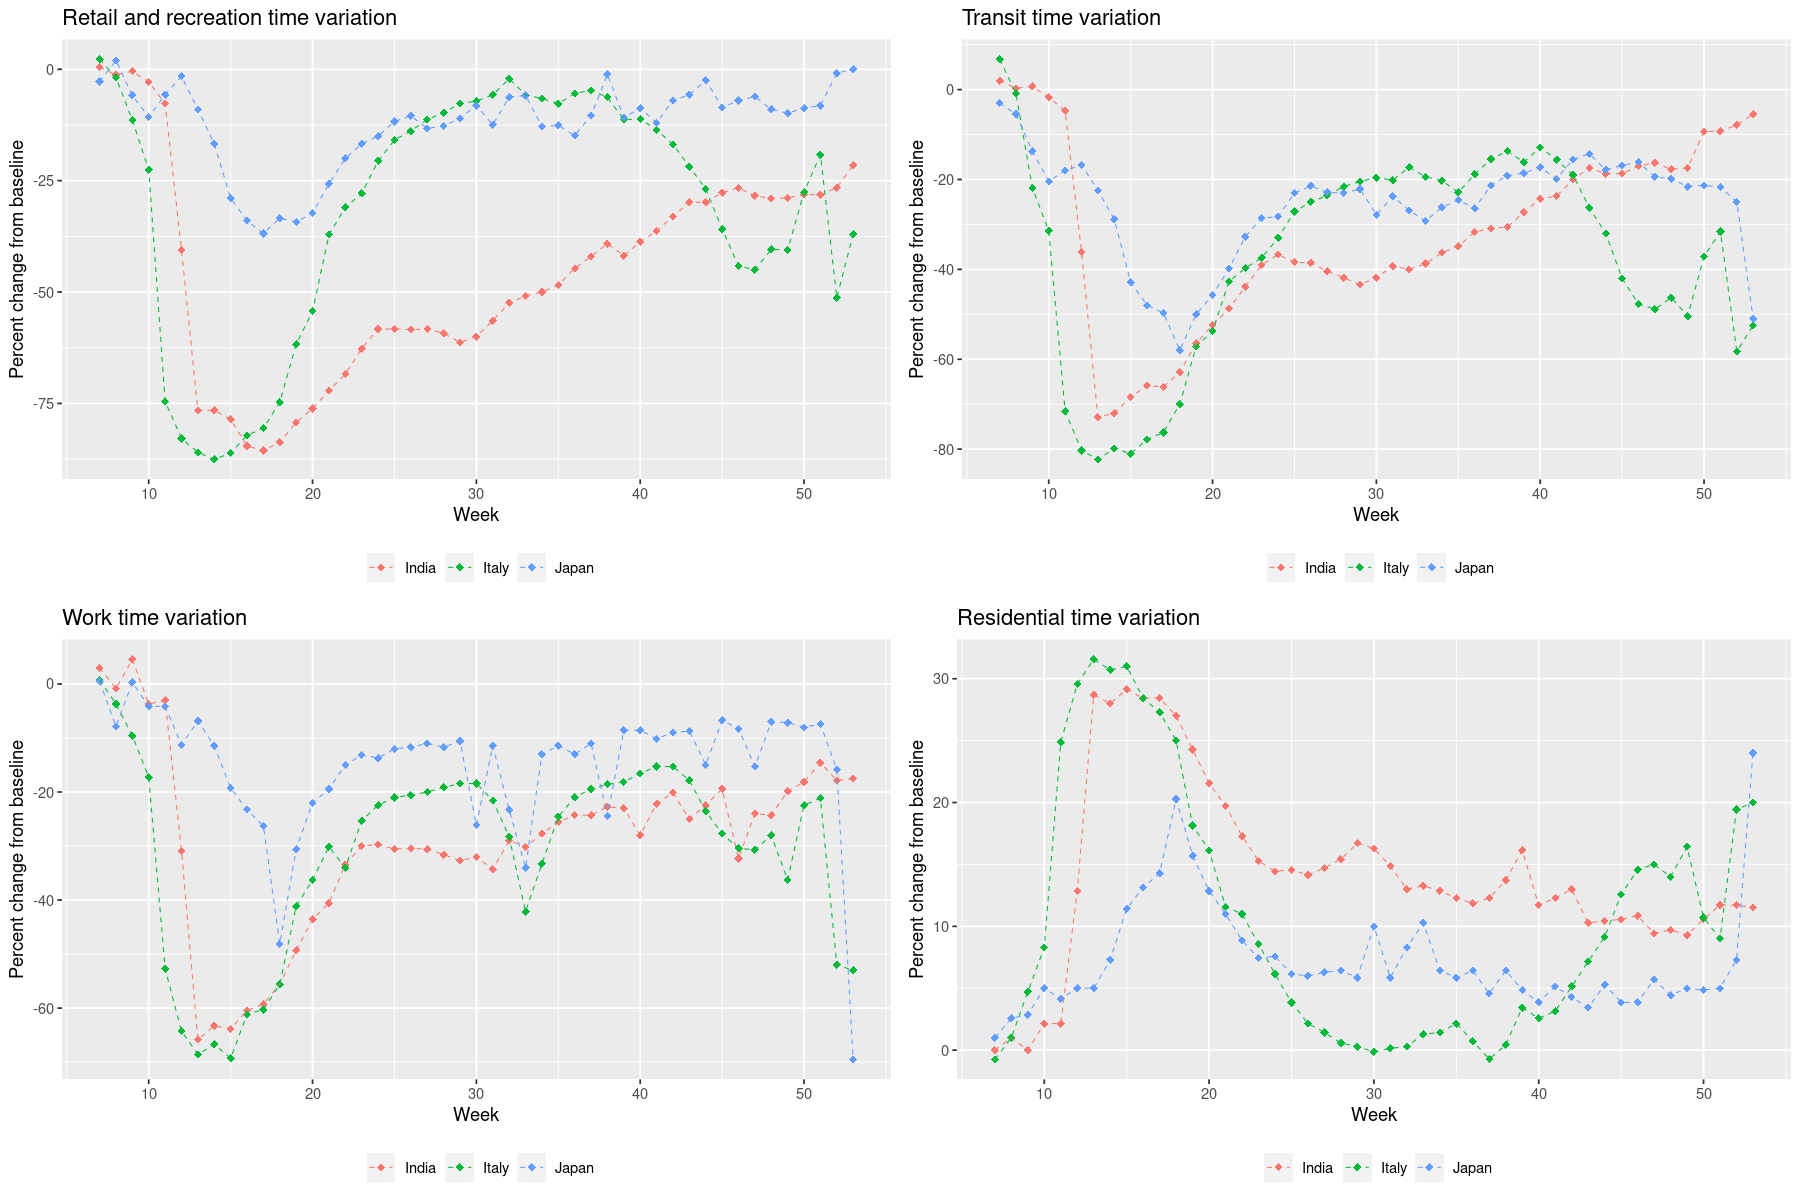

In [32]:
options(repr.plot.width=15, repr.plot.height=10)
p1=ggplot(data = week_gdata) + 
    geom_point(aes(x = date, y = ret_recr_mean, group = country_region,  color = country_region),shape=18, size =2) +
    geom_line(aes(x = date, y = ret_recr_mean, group = country_region,  color = country_region),linetype="dashed", size = 0.3) +
    labs( x="Week", y= "Percent change from baseline", color = "", title = "Retail and recreation time variation") +
    theme(legend.position="bottom")
p2=ggplot(data = week_gdata) + 
    geom_point(aes(x = date, y = transit_mean, group = country_region,  color = country_region),shape=18, size =2) +
    geom_line(aes(x = date, y = transit_mean, group = country_region,  color = country_region),linetype="dashed", size = 0.3) +
    labs( x="Week", y= "Percent change from baseline", color = "", title = "Transit time variation") +
    theme(legend.position="bottom")
p3=ggplot(data = week_gdata) + 
    geom_point(aes(x = date, y = work_mean, group = country_region,  color = country_region),shape=18, size =2) +
    geom_line(aes(x = date, y = work_mean, group = country_region,  color = country_region),linetype="dashed", size = 0.3) +
    labs( x="Week", y= "Percent change from baseline", color = "", title = "Work time variation") +
    theme(legend.position="bottom")
p4=ggplot(data = week_gdata) + 
    geom_point(aes(x = date, y = home_mean, group = country_region,  color = country_region),shape=18, size =2) +
    geom_line(aes(x = date, y = home_mean, group = country_region,  color = country_region),linetype="dashed", size = 0.3) +
    labs( x="Week", y= "Percent change from baseline", color = "", title = "Residential time variation")+
    theme(legend.position="bottom")
grid.arrange(p1,p2,p3,p4,ncol=2,nrow=2)

COVID-19 impact can be seen in each of these graphs. In particular the residential time increase and consequently the decrease for the other categories is evident for Italy and India. Japan seems to be an exception, since the different is not as large as the other countries.

In the following time period all these nations activities have been stabilized around a certain distance from the previous baseline.

As a last observation, one can see how in the last weeks for each graphs time variations seems to increase, probably because of new restrictions. In particular Japan seems to have increased a lot restriction, probably to 
deal with new virus variants.